## **Kako mašine uče?**

Sa tačke gledišta posmatrača, algoritam učenja je predstavljen pomoću ulaznih podataka koji su upareni sa željenim izlazima. Cilj je da nakon završetka procesa učenja, algoritam bude sposoban da proizvede ispravne izlaze kada mu se unesu novi podaci koji su dovoljno slični ulaznim podacima na kojima je obučen. Razvijeni modeli potrebno je da dobro aproksimiraju veze između ulaza i izlaza dok se pod procesom učenja podrazumeva estimacija vrednosti parametara modela.

**Zadatak 1:** Upravo smo se vratili sa putovanja i doneli smo kao suvenir stari, analogni termometar koji se savršeno uklapa na zid naše dnevne sobe. Njegova jedina mana je što ne pokazuje jedinice. Stoga, napravićemo skup podataka očitavanja i odgovarajućih temperaturnih vrednosti u našim omiljenim jedinicama, izabrati model, iterativno prilagođavati njegove težine sve dok mera greške ne bude dovoljno niska, kako bismo konačno mogli da protumačimo očitavanja u jedinicama koje razumemo. 

In [ ]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

Nakon nekoliko nedelja, izmerene su sledeće vrednosti i kreiran skup podataka.

In [ ]:
# izmerena temperatura u Celzijusima
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
# izmerene vrednosti na termometru u nepoznatim jedinicama
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# t_c - temperature (Celsius)
# t_u - temperature (unsigned)

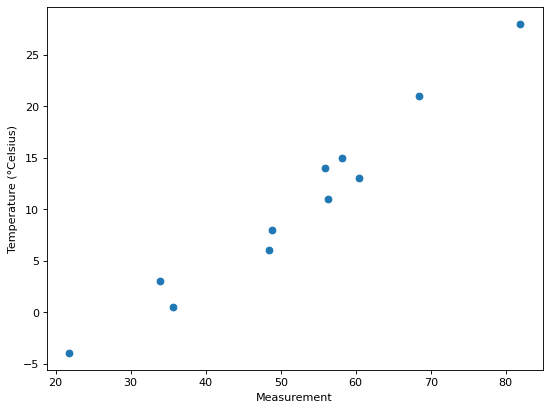

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

Kako nemamo više informacija o prirodi zakonitosti, biramo linearni model kao prvi pokušaj aproksimiranja zakonitosti. 

In [ ]:
def model(t_u, w, b):
    return w * t_u + b
    # w - weights
    # b - bias

Neophodno je da definišemo meru greške (*loss function*). Optimizacioni proces se sastoji iz traženja parametara *w* i *b*, tako da *loss function* bude minimalna. U ovom slučaju kreiramo tenzor koji predstavlja srednju kvadratnu grešku između dva tenzora. 

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
    # t_p - predicted temperature

In [ ]:
#inicijalizacija parametara

w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

Kako minimizovati loss function?

In [ ]:
# Broadcasting, p.112, Deep Learning with PyTorch
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


Loss function ćemo optimizovati u odnosu na parametre koristeći Gradient descent algoritam. Ovim iterativnim algoritmom pronalazimo lokalni minimum/maksimum date funkcije.

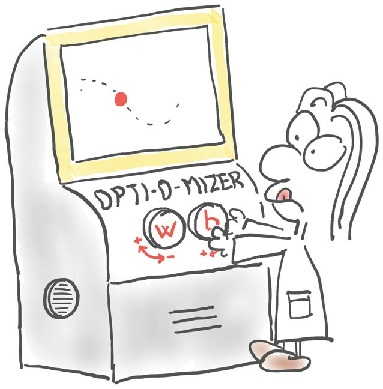

In [ ]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

U okolini trenutnih vrednosti w i b, jedinično povećanje w dovodi do promene loss function. Ako je promena negativna, onda moramo povećati w da bismo minimizovali gubitak, dok ako je promena pozitivna, moramo smanjiti w. W menjamo proporcionalno promeni gubitka. Dobra praksa je da promene skaliramo tako da budu spore, tako da se uvodi learning rate kao parametar učenja. Sličnu logiku koristimo i za promenu b parametra. 

In [ ]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [ ]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

U prethodnom delu koda izabrali smo da je delta = 0.1. Međutim, vrednost zavisi od oblika loss funkcije. Ako se loss funkcija menja previše brzo sa promenom delta, nemamo dobru intuiciju o tome u kom smeru se gubitak kreće. 

U modelu sa dva ili više parametara kao što je ovaj kojim se bavimo, izračunavamo pojedinačne izvode loss funkcije u odnosu na svaki parametar i stavljamo ih u vektor izvoda: gradijent.

d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w)

Kako je d x^2 / d x = 2 x, dobijamo:

In [ ]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1> The division is from the derivative of mean.
    return dsq_diffs

Kako je model w * t_u + b, imamo:

In [ ]:
def dmodel_dw(t_u, w, b):
    return t_u

In [ ]:
def dmodel_db(t_u, w, b):
    return 1.0

Gradijent:

In [ ]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1> Sumiranje je obrnuto od emitovanja koje implicitno radimo kada primenjujemo parametre na ceo vektor ulaza u modelu.

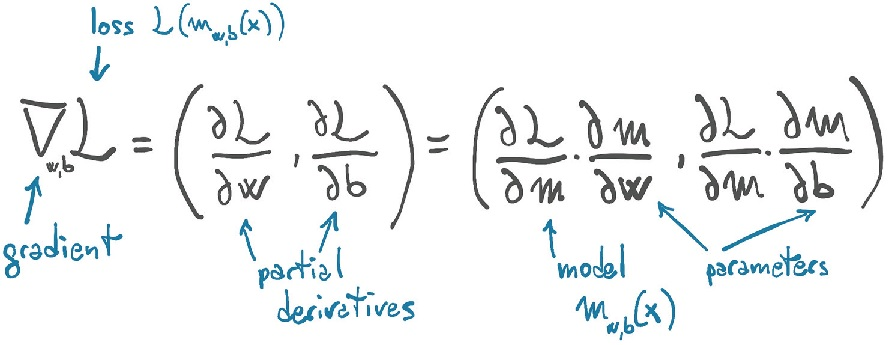

### **Iterativni postupak**

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1> Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2> Backward pass

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3> This logging line.

        if (epoch < 3):
          print(grad)
        
            
    return params

In [ ]:
"""
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params
"""

Primer optimizacionog procesa koji nije stabilan i divergira umesto da konvergira ka minimumu.

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epo

tensor([nan, nan])

Ideja: smanjiti learning rate parametar. Međutim, promene parametara su veoma male i loss se sporo smanjuje.

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540283
Epoch 6, Loss 29.351154
Epoch 7, Loss 29.148884
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105247
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102295
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100466
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097717
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095881
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092216
Epoch 25, Loss 29.091301
Epoch 26, Loss 29.090385
Epoch 27, Loss 29.089464
Epoch 28, Loss 29.088551
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086714
Epoch 31, Loss 29.085804
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083967
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081221
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.0

tensor([ 0.2327, -0.0438])

Learning rate se može i adaptivno menjati i mogu se primenjivati različite optimizacione šeme. 

Može se primetiti da je gradijent za parametar w 50 puta veći nego gradijent za b u prvoj epohi. To znači da su ovi gradijenti u različitim prostorima, što znači da je learning rate koji je dovoljno veliki za promene u jednom prostoru, isuviše mali za promene u drugom. Moguće je imati različite learning rate parametre za svaki od parametara, ali to nije praktično za modele sa mnogo parametara. 

**Rešenje**: izvršiti normalizaciju ulaznih podataka, s ciljem ostvarivanja opsega približnog opsegu (-1, 1). 

In [ ]:
t_un = 0.1 * t_u

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.364342
tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
E

tensor([ 2.7553, -2.5162])

In [ ]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    #print_params = False
    )

params

Streaming output truncated to the last 5000 lines.
Epoch 2, Loss 37.574913
tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epo

tensor([  5.3671, -17.3012])

Ostvareni loss nije blizak nuli što može značiti da je potrebno još iteracija ili da naši podaci nisu dovoljno precizno očitani da pripadaju istoj pravoj (tj. postoji šum). 

In [ ]:
print(params)
# može se zaključiti da ovakvi parametri odgovaraju konverziji skala Farenhajt u Celzijus

tensor([  5.3671, -17.3012])


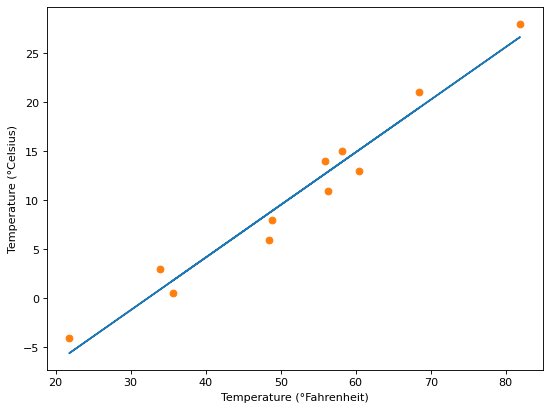

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(figsize=(8,6), dpi=80)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

## **Literatura:**

Edi Stevens, Luca Antiga, Thomas Viehman, Deep learning with PyTorch, Manning, 2020. Chapter 5